In [1]:
import os
os.environ['KAGGLE_USERNAME']="spmithun"
os.environ['KAGGLE_KEY']="602aff81f54ea56a33e7a216b2491451"

!kaggle datasets download -d mohitsingh1804/plantvillage

100% 815M/818M [00:34<00:00, 25.9MB/s]
100% 818M/818M [00:34<00:00, 24.7MB/s]


In [2]:
!unzip /content/plantvillage.zip

Streaming output truncated to the last 5000 lines.
  inflating: PlantVillage/val/Soybean___healthy/52c7d07b-561b-4380-801a-3824e65a5135___RS_HL 3797.JPG  
  inflating: PlantVillage/val/Soybean___healthy/53168d1c-ac90-4039-9eff-7479475a6b74___RS_HL 6355.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5344b09f-bbbe-4a2c-9345-d93dd4e69eb4___RS_HL 4693.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5361ba4a-351e-466c-99c5-8845f35c00df___RS_HL 2890.JPG  
  inflating: PlantVillage/val/Soybean___healthy/537e5409-d824-4859-967f-3c502f13deec___RS_HL 5474.JPG  
  inflating: PlantVillage/val/Soybean___healthy/538969da-545b-4bce-bc1d-0932898dc5e6___RS_HL 5230.JPG  
  inflating: PlantVillage/val/Soybean___healthy/538ccfe2-1509-40d7-beae-ae7cf84e1e5d___RS_HL 3717.JPG  
  inflating: PlantVillage/val/Soybean___healthy/5397bf6a-aeeb-4f1c-b554-bdb604bb23c3___RS_HL 6508.JPG  
  inflating: PlantVillage/val/Soybean___healthy/53dc0466-621c-43e1-9c5e-e340f3d50171___RS_HL 6381.JPG  
  inflating: 

In [3]:
     # Reading Data
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# Data Preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Building CNN Model & Pretraining Model
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, AveragePooling2D, Flatten, Dropout

# Downlaod Model
import pickle

In [4]:
train_path="/content/PlantVillage/train"
val_path="/content/PlantVillage/val"

In [5]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255)
eval_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [6]:
train_generator = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

validation_generator = eval_datagen.flow_from_directory(val_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 43444 images belonging to 38 classes.
Found 10861 images belonging to 38 classes.


In [7]:
num_classes=train_generator.num_classes
nb_train_samples = train_generator.samples
nb_val_samples = validation_generator.samples

In [8]:
base_model=tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224, 224, 3))

80134624/80134624 [==============================] - 4s 0us/step


In [9]:
def prepare_VGG_model_for_finetuning(freeze_baselayers=True):
    """
    input_shape: When pretrained networks are utilised, the input shape for the network is generally
    dependent on the shape of the data the pretrained networks were originally trained. It allows us the exact use of weights.++
    """
    base_model=tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224, 224, 3))    # freeze layers
    if freeze_baselayers==True:
        for layer in base_model.layers:
            layer.trainable=False
    # change here - take the output from different layers of the base model. Eg. base_model.output, base_model.layers[11].output
    x =  base_model.output
    # x = tf.keras.layers.GlobalAveragePooling2D(2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dense(num_classes)(x)
    prediction_layer = tf.keras.layers.Softmax()(x)
    model_new = tf.keras.Model(inputs=base_model.input, outputs=prediction_layer)
    return model_new

In [10]:
model = prepare_VGG_model_for_finetuning(freeze_baselayers=True)

In [11]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer_fn = tf.keras.optimizers.Adam(learning_rate=0.001)

In [12]:
model.compile(optimizer=optimizer_fn,
              loss=loss_fn,
              metrics=['accuracy'])

In [13]:
history = model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//32,
                   epochs=10, validation_data=validation_generator,
                    validation_steps=nb_val_samples/32)

Epoch 1/10


<ipython-input-13-c4853c708d8c>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//32,
/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5562: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1357/1357 [==============================] - 271s 189ms/step - loss: 1.0414 - accuracy: 0.7006 - val_loss: 0.6165 - val_accuracy: 0.8034
Epoch 2/10
1357/1357 [==============================] - 256s 189ms/step - loss: 0.4506 - accuracy: 0.8532 - val_loss: 0.4560 - val_accuracy: 0.8527
Epoch 3/10
1357/1357 [==============================] - 255s 188ms/step - loss: 0.3226 - accuracy: 0.8946 - val_loss: 0.3600 - val_accuracy: 0.8823
Epoch 4/10
1357/1357 [==============================] - 256s 188ms/step - loss: 0.2515 - accuracy: 0.9169 - val_loss: 0.3145 - val_accuracy: 0.8995
Epoch 5/10
1357/1357 [==============================] - 255s 188ms/step - loss: 0.1979 - accuracy: 0.9353 - val_loss: 0.3036 - val_accuracy: 0.9015
Epoch 6/10
1357/1357 [==============================] - 255s 188ms/step - loss: 0.1639 - accuracy: 0.9451 - val_loss: 0.3507 - val_accuracy: 0.8899
Epoch 7/10
1357/1357 [==============================] - 287s 212ms/step - loss: 0.1336 - accuracy: 0.9569 - val_loss: 0.339

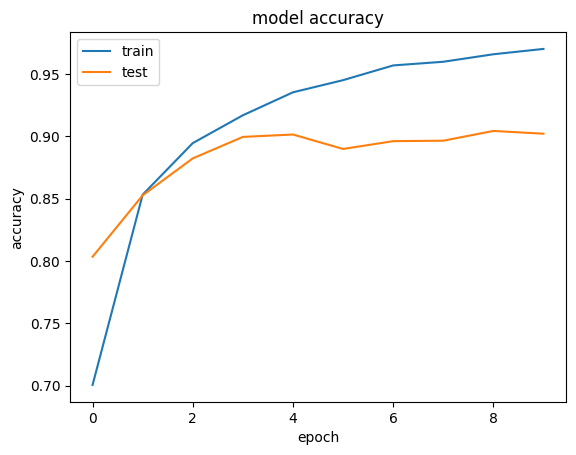

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history[ "accuracy"])
plt.plot(history.history[ "val_accuracy"])
plt.title("model accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train","test"], loc="upper left")
plt.show()

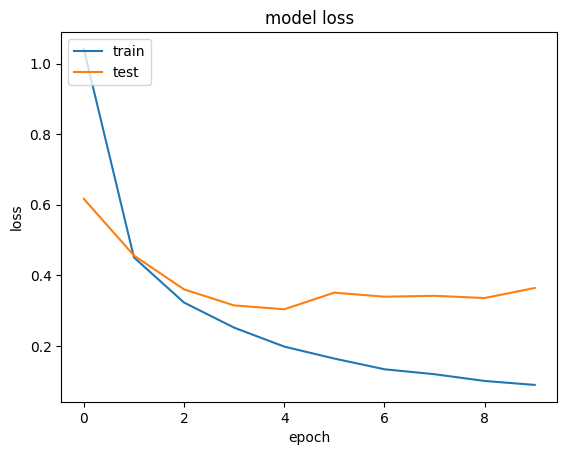

In [15]:
plt.plot(history.history[ "loss"])
plt.plot(history.history[ "val_loss"])
plt.title("model loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train","test"], loc="upper left")
plt.show()

In [16]:
model.save("modelVGG19.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
score = model.evaluate(validation_generator)
print(model.metrics_names)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

340/340 [==============================] - 52s 153ms/step - loss: 0.3640 - accuracy: 0.9021
['loss', 'accuracy']
accuracy: 90.21%


In [18]:
model.save_weights("model_weights.h5")

In [19]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 98.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.3 MB/s eta 0:00:00


In [23]:
test_img, test_lbl = validation_generator.__next__()
predictions=model.predict(test_img)

predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

1/1 [==============================] - 0s 213ms/step
Accuracy =  0.84375


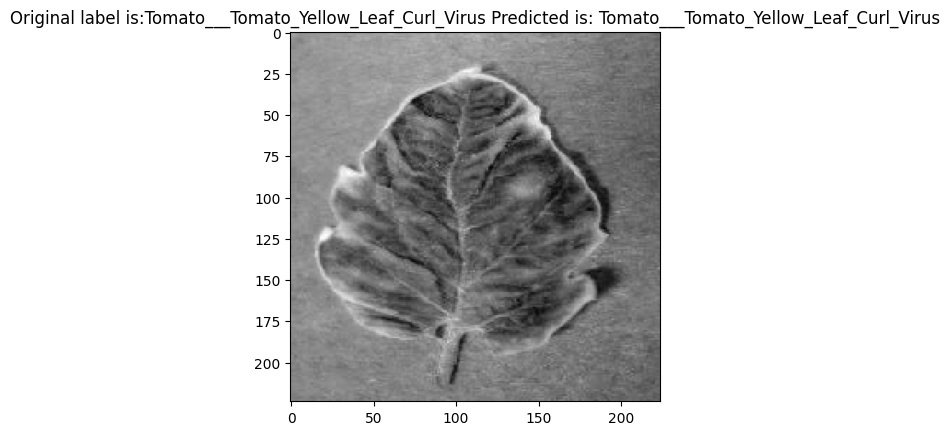

In [27]:
import random
class_labels=['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
#Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()

In [35]:
import pandas as pd
df=pd.read_csv("/content/predictions.csv", encoding='ISO-8859-1')
df

,predictions,solutions,Unnamed: 2,Unnamed: 3
0,Apple___Apple_scab,"dodine, captan or dinathion",NaN,NaN
1,Apple___Black_rot,Captan and sulfur,NaN,NaN
2,Apple___healthy,mid amount of captan,NaN,NaN
3,Apple___Cedar_apple_rus,Myclobutanil,NaN,NaN
4,Blueberry___healthy,organophosphates,NaN,NaN
5,Cherry_(including_sour)___Powdery_mildew,Quash metconazole,NaN,NaN
6,Cherry_(including_sour)___healthy,no need,NaN,NaN
7,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,pyraclostrobin,NaN,NaN
8,Corn_(maize)___Common_rust_,chlorothalonil,NaN,NaN
9,Corn_(maize)___Northern_Leaf_Blight,chlorothalonil,NaN,NaN


In [36]:
df = df.iloc[:, :-2]
df

,predictions,solutions
0,Apple___Apple_scab,"dodine, captan or dinathion"
1,Apple___Black_rot,Captan and sulfur
2,Apple___healthy,mid amount of captan
3,Apple___Cedar_apple_rus,Myclobutanil
4,Blueberry___healthy,organophosphates
5,Cherry_(including_sour)___Powdery_mildew,Quash metconazole
6,Cherry_(including_sour)___healthy,no need
7,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,pyraclostrobin
8,Corn_(maize)___Common_rust_,chlorothalonil
9,Corn_(maize)___Northern_Leaf_Blight,chlorothalonil


In [37]:
filtered_df = df[df['predictions'] == pred_labl]
if not filtered_df.empty:
    # Print the solution for 'Grape___Black_rot'
    solution = filtered_df['solutions'].iloc[0]
    print("Solution for", pred_labl,":", solution)
else:
    print("prediction not found in the DataFrame.")

Solution for Tomato___Tomato_Yellow_Leaf_Curl_Virus : pyrethroids
